# Домашнее задание 2. Классификация, детекция.

Выполнил: Глеб, ИАД-4

Оценка за часть 1 и часть 2 в этом дз — по 5 баллов.

Импортируем все необходимые библиотеки:

In [3]:
import torch
import torchvision
from torchvision import transforms
from torch import nn
import torch.optim as optim
from torch.nn import functional as F

import numpy as np
from sklearn.metrics import accuracy_score

# Графики 
import matplotlib.pyplot as plt
from IPython.display import clear_output
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 8

%matplotlib inline
%config InlineBackend.figure_format ='retina'

# Разное
from PIL import Image
from PIL import ImageDraw
from tqdm import tqdm
import os
import sys
import itertools
import random

import warnings
warnings.filterwarnings('ignore')

Код для фиксирования сида:

In [4]:
torch.set_deterministic(True)

def seed_everything(num:int):
    random.seed(num)
    np.random.seed(num)
    torch.manual_seed(num)

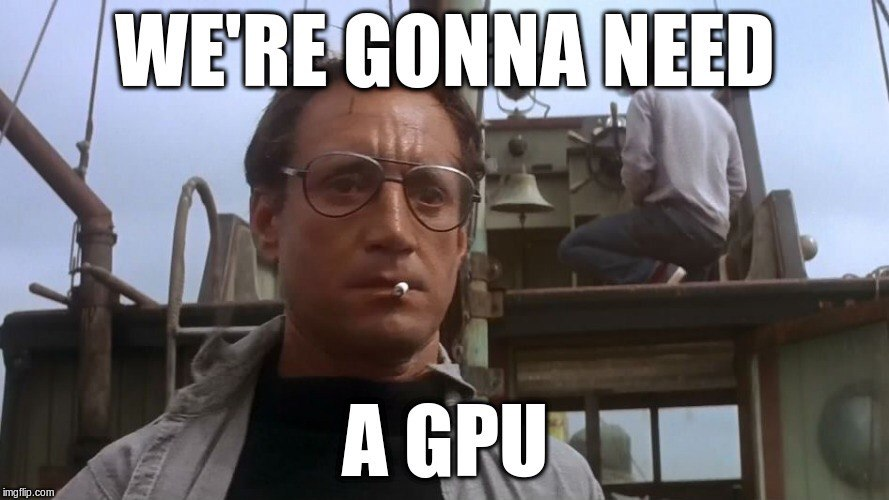

In [5]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

## Часть 1. Классификация

В этом задании потребуется обучить классификатор изображений. Будем работать с датасетом, название которого раскрывать не будем. Можете посмотреть самостоятельно на картинки, которые в датасете есть. В нём 200 классов и около 5 тысяч картинок на каждый класс. Классы пронумерованы, как нетрудно догадаться, от 0 до 199. Скачать датасет можно вот [тут](https://yadi.sk/d/BNR41Vu3y0c7qA).

Структура датасета простая -- есть директории train и val, в которых лежат обучающие и валидационные данные. В train/ и val/ лежат директориии, соответствующие классам изображений, в которых лежат собственно сами изображения.
 
__Задание__. Добейтесь accuracy **не менее 0.44**. Напишите краткий отчёт о проделанных экспериментах. Что сработало и что не сработало? Почему вы решили, сделать так, а не иначе? Обязательно указывайте ссылки на чужой код, если вы его используете. Обязательно ссылайтесь на статьи/блогпосты/вопросы на stackoverflow/видосы от (индийских) ютуберов/курсы/подсказки от Дяди Васи и прочие дополнительные материалы, если вы их используете. 

В коде ниже необходимо, чтобы код проходил все `assert`'ы.

Необходимо написать функцию `predict` по шаблону ниже. Эта функция принимает на вход модель, даталоадер с валидационнами данными, criterion для подсчёта лосса и device, на котором будут производиться вычисления (определён ниже) и возвращает список лоссов по всем объектам, список из предсказанных классов для каждого объекта из из даталоалера и список из настоящих классов для каждого объекта в даталоадере (и именно в таком порядке).

__Использовать внешние данные для обучения строго запрещено__. Можно использовать предобученные модели из `torchvision`.

__Критерии оценки__: Оценка вычисляется по простой формуле: min(5, 5 * Ваша accuracy / 0.44). Оценка округляется до десятых по арифметическим правилам.

__Советы и указания__:
 - Наверняка вам потребуется много гуглить о классификации и о том, как заставить её работать. Это нормально, все гуглят. Но не забывайте, что нужно быть готовым за скатанный код отвечать на защите :)
 - Используйте аугментации. Для этого пользуйтесь модулем torchvision.transforms или библиотекой [albumentations](https://github.com/albumentations-team/albumentations)
 - (ещё раз) Можно файнтюнить предобученные модели из `torchvision`.
 - Рекомендуем написать вам сначала класс-датасет (или воспользоваться классом ImageFolder), который возвращает картинки и соответствующие им классы, а затем функции для трейна по шаблонам ниже. Однако делать это мы не заставляем. Если вам так неудобно, то можете писать код в удобном стиле. Однако учтите, что чрезмерное изменение нижеперечисленных шаблонов увеличит количество вопросов к вашему коду и повысит вероятность вызова на защиту :)
 - Валидируйте. Трекайте ошибки как можно раньше, чтобы не тратить время впустую.
 - Чтобы отладить код, пробуйте обучаться на маленькой части датасета. Когда вы поняли, что смогли всё отдебажить, переходите обучению по всему датасету
 - На каждый запуск делайте ровно одно изменение в модели/аугментации/оптимайзере, чтобы понять, что и как влияет на результат.
 - Фиксируйте random seed.
 - Начинайте с простых моделей и постепенно переходите к сложным. Обучение лёгких моделей экономит много времени.
 - Ставьте расписание на learning rate. Уменьшайте его, когда лосс на валидации перестаёт убывать.
 - Советуем использовать гпу. Если у вас его нет, используйте google colab. Если вам неудобно его использовать на постоянной основе, напишите и отладьте весь код локально на CPU, а затем запустите уже написанный ноутбук в колабе. Авторское решение задания достигает требуемой точности в колабе за 15 минут обучения.

Скачаем датасет. Через Яндекс почему-то не скачивается, так что создал ссылку на Dropbox.

In [4]:
!wget https://www.dropbox.com/s/5btu7ieyat87xpl/dataset.zip?dl=0 -O dataset.zip

--2020-11-24 13:08:19--  https://www.dropbox.com/s/5btu7ieyat87xpl/dataset.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.1, 2620:100:6016:1::a27d:101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/5btu7ieyat87xpl/dataset.zip [following]
--2020-11-24 13:08:19--  https://www.dropbox.com/s/raw/5btu7ieyat87xpl/dataset.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc1712a9565642efc7f882a100da.dl.dropboxusercontent.com/cd/0/inline/BDwgQ1rFKHxrbrXy_SLWEa053LJlKCeelsK3wwkVjHsWw7MZf0d8402a_T84eWxbExDEwvZbFoQX2hCn_gwTKoplwgd5gyHIYD93FDcuoWNoPkwoPBrFd_sASGy6DAvmcFI/file# [following]
--2020-11-24 13:08:19--  https://uc1712a9565642efc7f882a100da.dl.dropboxusercontent.com/cd/0/inline/BDwgQ1rFKHxrbrXy_SLWEa053LJlKCeelsK3wwkVjHsWw7MZf0d8402a_T84eWxbExDEwvZbFoQX2hCn_gwTKoplwgd5gyHIYD93FDcuoWNoPkwo

In [5]:
!unzip -q dataset.zip

replace dataset/dataset/train/class_000/00000.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


Посмотрим что лежит в нашем датасете.

In [6]:
!ls dataset/dataset

train  val


Как видим, картинки по классам для обучающей и тестовой выборок.

In [7]:
!ls dataset/dataset/train

class_000  class_029  class_058  class_087  class_116  class_145  class_174
class_001  class_030  class_059  class_088  class_117  class_146  class_175
class_002  class_031  class_060  class_089  class_118  class_147  class_176
class_003  class_032  class_061  class_090  class_119  class_148  class_177
class_004  class_033  class_062  class_091  class_120  class_149  class_178
class_005  class_034  class_063  class_092  class_121  class_150  class_179
class_006  class_035  class_064  class_093  class_122  class_151  class_180
class_007  class_036  class_065  class_094  class_123  class_152  class_181
class_008  class_037  class_066  class_095  class_124  class_153  class_182
class_009  class_038  class_067  class_096  class_125  class_154  class_183
class_010  class_039  class_068  class_097  class_126  class_155  class_184
class_011  class_040  class_069  class_098  class_127  class_156  class_185
class_012  class_041  class_070  class_099  class_128  class_157  class_186
class_013  c

Создадим наш кастомный датасет.

Сначала определим вспомогательные функции, которые создают путь к картинкам.

In [8]:
from os.path import isfile, join

def cat_classes(path):
    """
    Args:
      path: путь к папке с классами (e.g. './dataset/dataset/train/').
    """
    # Выводим все классы в нашей выборке
    dirs = os.listdir(path) 
    # Сортируем классы
    dirs.sort()
    # Соединяем все классы с нашим путем
    # e.g. classes_dir[0] = './dataset/dataset/train/class_000'
    classes_dir = [join(path, i) for i in dirs]

    return classes_dir

def cat_images(path):
    """
    Args:
      path: путь к картинкам определенного класса (e.g. './dataset/dataset/train/class_000').
    """
    # Выводим все картинки в нашем классе
    dirs = os.listdir(path) 
    # Сортируем картинки
    dirs.sort()
    # Соединяем все картинки с нашим путем, также не забываем проверить, действительно ли это файл
    # e.g. images_dir[0] = './dataset/dataset/train/class_000/00000.jpg'
    images_dir = [join(path, i) for i in dirs if isfile(join(path, i))] 
    
    return images_dir

Посмотрим, как работает.

In [9]:
cat_classes("./dataset/dataset/train")[:5]

['./dataset/dataset/train/class_000',
 './dataset/dataset/train/class_001',
 './dataset/dataset/train/class_002',
 './dataset/dataset/train/class_003',
 './dataset/dataset/train/class_004']

In [10]:
cat_images('./dataset/dataset/train/class_000')[:5]

['./dataset/dataset/train/class_000/00000.jpg',
 './dataset/dataset/train/class_000/00001.jpg',
 './dataset/dataset/train/class_000/00002.jpg',
 './dataset/dataset/train/class_000/00003.jpg',
 './dataset/dataset/train/class_000/00004.jpg']

Все супер.

In [11]:
# Для себя
# [cat_images(i) for i in cat_classes("./dataset/dataset/train")]

In [12]:
# list2d = [[1,2,3], [4,5,6], [7], [8,9]]
# merged = list(itertools.chain(*list2d))
# merged

In [13]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir: путь к папке с данными.
            transform: трансформируем картинки и их ответы.
        """
        # Наш путь к выборке
        self.root_dir = os.path.expanduser(root_dir)
        # Используем transform, если специфицировали его
        self.transform = transform
        # Лист с путями к классам
        self.classes_path = cat_classes(root_dir)
        # Лист с путями к картинке каждого класса
        self.images_path = [cat_images(i) for i in self.classes_path]
        # Лист с классами [[0, ..., 0], ..., [199, ..., 199]]
        self.labels_path = [[i for j in range(len(self.images_path[i]))] 
                             for i in range(len(self.images_path))]

        # Теперь из листа листов сделаем один лист, то есть из [[...], ..., [...]] сделаем [...]
        self.images_path = list(itertools.chain(*self.images_path))
        self.labels_path = list(itertools.chain(*self.labels_path))

    def __getitem__(self, idx):
        """
        Возвращает кортеж (картинка, класс).

        Args: 
            idx: номер картинки в выборке.
        """
        # Получаем нашу картинку и еще переводим ее в RGB, если она изначально была ЧБ
        image = Image.open(self.images_path[idx]).convert('RGB')
        label = self.labels_path[idx]

        if self.transform is not None:
            image = self.transform(image)

        return (image, label)

    def __len__(self):
        """
        Возвращает размер выборки.
        """
    
        return len(self.images_path)      

Создаем обучающую и тестовую выборки.

In [21]:
seed_everything(77)

# Для обучающей выборки используем также аугментацию
train_dataset = MyDataset("./dataset/dataset/train", 
                          transform=transforms.Compose([transforms.Resize((256, 256)),
                                                        transforms.ColorJitter(hue=.05, saturation=.05),
                                                        transforms.RandomHorizontalFlip(),
                                                        transforms.RandomRotation(20, resample=Image.BILINEAR),
                                                        transforms.ToTensor()]))

test_dataset = MyDataset("./dataset/dataset/val",
                         transform=transforms.Compose([transforms.Resize((256, 256)),
                                                       transforms.ToTensor()]))

Посмотрим, все ли работает.

In [22]:
image, label = train_dataset.__getitem__(0) 
label

0

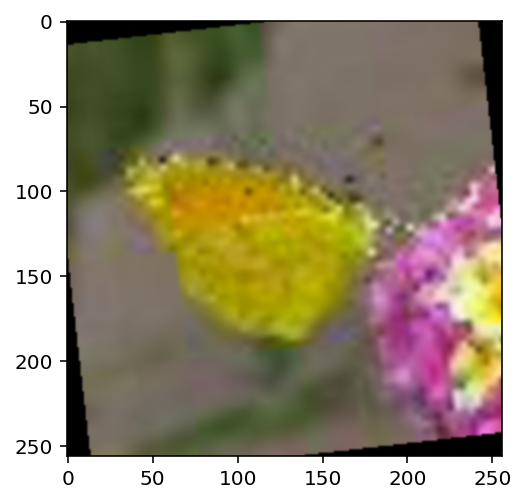

In [23]:
plt.imshow(transforms.ToPILImage()(image), interpolation="bicubic");

Да!

In [24]:
# Just very simple checks
assert isinstance(train_dataset[0], tuple)
assert len(train_dataset[0]) == 2
assert isinstance(train_dataset[1][1], int)
print("Tests passed.")

Tests passed.


Создадим даталоадеры.

In [25]:
from torch.utils.data import DataLoader

seed_everything(77)
train_dataloader = DataLoader(train_dataset, batch_size=20, shuffle=True, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=20, num_workers=2)

 Напишим код для обучающего цикла. В основном буду опираться на [код](https://github.com/khaykingleb/Deep-Learning/blob/master/homeworks/hw_01/hw_01.ipynb) из прошлого д/з.

In [26]:
plt.style.use('ggplot')

def plot_metric(train_metric, test_metric, title):
    plt.figure()
    plt.title(f'Значение {title} в зависимости от шагов (1 эпоха = {len(train_dataloader)} шагов)',  
              pad=10, fontsize=18, loc='left')
    plt.ylabel(f'{title}', labelpad=10, fontsize=14)
    plt.xlabel('Количество шагов', labelpad=10, fontsize=14)
    plt.plot(train_metric, label='train', zorder=1)
  
    steps = list(range(0, len(train_metric) + 1, int(len(train_metric) / len(test_metric))))[1:]
    plt.scatter(steps, test_metric, marker='+', s=180, c='orange', label='test', zorder=2)
  
    plt.legend(loc='best')
    plt.grid()

    plt.show()


def train_one_epoch(model, train_dataloader, criterion, optimizer, device):
    model.train()

    history_train_loss_by_step = []
    history_train_acc_by_step = []

    with tqdm(total=len(train_dataloader), file=sys.stdout) as prbar:
        for batch in train_dataloader:
            images, labels = batch[0].to(device), batch[1].to(device)

            # Делаем предсказания
            y_pred = model(images)
            # Считаем лосс: y_pred — это матрица N x C, где N — количество картинок
            loss = criterion(y_pred, labels)  

            # Подсчитываем градиенты
            loss.backward()
            # Делаем шаг оптимизации
            optimizer.step()
            # Обнуляем посчитанные градиенты
            optimizer.zero_grad()

            # Усредняем лосс по батчу
            loss_accum = loss.item()
            batch_size = y_pred.shape[0]
            batch_loss = loss_accum / batch_size

            # Считаем долю верных предсказаний
            y_pred_class = torch.max(y_pred, axis=1)[1]
            num_pred_correct = (y_pred_class == labels).sum().item()
            batch_accuracy = num_pred_correct / batch_size

            # Добавляем метрики батча в список
            history_train_loss_by_step.append(batch_loss)
            history_train_acc_by_step.append(batch_accuracy)

            # Обновляем prbar
            prbar.set_description(
                  f'Loss: {batch_loss:.4}, '
                  f'Accuracy: {batch_accuracy * 100:.4}%'
            )
            prbar.update(1)

    return history_train_loss_by_step, history_train_acc_by_step


def predict(model, test_dataloader, criterion, device):
    model.eval()
   
    test_loss = 0
    test_acc = 0
    steps = len(test_dataloader) 

    pred_classes = []
    true_labels = []

    with torch.no_grad() and tqdm(total=len(test_dataloader), file=sys.stdout) as prbar:
        for batch in test_dataloader:
            images, labels = batch[0].to(device), batch[1].to(device)

            # Делаем предсказания
            y_pred = model(images)
            # Считаем лосс: y_pred — это матрица N x C, где N — количество картинок
            loss = criterion(y_pred, labels)

            # Усредняем лосс по батчу
            loss_accum = loss.item()
            batch_size = y_pred.shape[0]
            batch_loss = loss_accum / batch_size

            # Считаем долю верных предсказаний
            y_pred_class = torch.max(y_pred, axis=1)[1]
            num_pred_correct = (y_pred_class == labels).sum().item()
            batch_accuracy = num_pred_correct / batch_size

            test_loss += batch_loss
            test_acc += batch_accuracy

            pred_classes.append(y_pred_class)
            true_labels.append(labels)

            # Обновляем prbar
            prbar.set_description(
                f'Loss: {batch_loss:.4}, '
                f'Accuracy: {batch_accuracy * 100:.4}%'
            )
            prbar.update(1)

    test_loss /= steps
    test_acc /= steps

    return test_loss, test_acc, pred_classes, true_labels


def train(model, train_dataloader, test_dataloader, criterion, optimizer, device, n_epochs=10, scheduler=None):
    model.to(device)

    history_train_loss_by_step = []
    history_test_loss_by_epoch = []

    history_train_acc_by_step = []
    history_test_acc_by_epoch = []

    for epoch in range(n_epochs):
        print(f"Train Epoch: {epoch}") 
        batch_loss, batch_accuracy = train_one_epoch(model, train_dataloader, 
                                                     criterion, optimizer, device)
        history_train_loss_by_step.extend(batch_loss)
        history_train_acc_by_step.extend(batch_accuracy)

        print(f"Test Epoch: {epoch}")
        test_loss, test_acc, pred_classes, labels = predict(model, test_dataloader,
                                                            criterion, device)
        history_test_loss_by_epoch.append(test_loss)
        history_test_acc_by_epoch.append(test_acc)

        clear_output()

        plot_metric(history_train_loss_by_step, history_test_loss_by_epoch, "Loss")
        plot_metric(history_train_acc_by_step, history_test_acc_by_epoch, "Accuracy")

        print(f"Test loss: {history_test_loss_by_epoch[-1]:.4}")
        print(f"Test accuracy: {history_test_acc_by_epoch[-1] * 100:.4}%")


In [27]:
# Модель для проверки правильности кода (далее исользовать не будем)
model = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Conv2d(32, 64, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Conv2d(64, 128, kernel_size=3),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Flatten(),
    nn.Linear(115200, 1600),
    nn.ReLU(), 
    nn.Dropout(),
    nn.Linear(1600, 800),
    nn.ReLU(), 
    nn.Linear(800, 200),
    nn.Softmax(dim=-1) 
).to(device)

optimizer = optim.RMSprop(model.parameters(), lr=0.01, alpha=0.99)
criterion = nn.CrossEntropyLoss()
scheduler = None
n_epochs = 10

В батче у нас будет по 20 картинок RGB.

In [28]:
for batch in train_dataloader:
  images, labels = batch
  print(images.shape)
  print(labels)
  break

torch.Size([20, 3, 256, 256])
tensor([ 22, 132, 183,  12,  93,  39, 138,   0, 160, 190,  32,  26, 180,  52,
        171,  58,  15,  63,  82, 180])


Простой тест на проверку правильности написанного кода

In [29]:
test_loss, _, predicted_labels, true_labels = predict(model, test_dataloader, criterion, device)
assert len(predicted_labels) == len(test_dataloader)
# Расстягиваем лист листов в вектор, иначе долю верных ответов не посчитать
predicted_labels = torch.hstack(predicted_labels).to("cpu")
true_labels = torch.hstack(true_labels).to("cpu")
accuracy = accuracy_score(predicted_labels, true_labels)
print("Tests passed.")

Loss: 0.2649, Accuracy: 100.0%: 100%|██████████| 500/500 [00:41<00:00, 11.92it/s]
Tests passed.


Все работает. Переходим теперь к реальному обучению моделей.

Попробуем использовать предобученные модели, поскольку на собственных моделях качество получается низкое (не вставлял эту часть в д/з).

In [30]:
#освободим память
del model

Возьмем ResNet-152, которая изначально обучалась классифицировать объекты на 1000 классов.

In [31]:
from torchvision.models import resnet152
model = resnet152(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

Посмотрим на архитектуру этой нейросети.

In [32]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Заменим последний полносвязный слой и обучим его. В качестве оптимизатора возьмем Adam.

In [33]:
model.fc = nn.Linear(2048, 200)
optimizer = torch.optim.Adam(model.fc.parameters(), 1e-4)

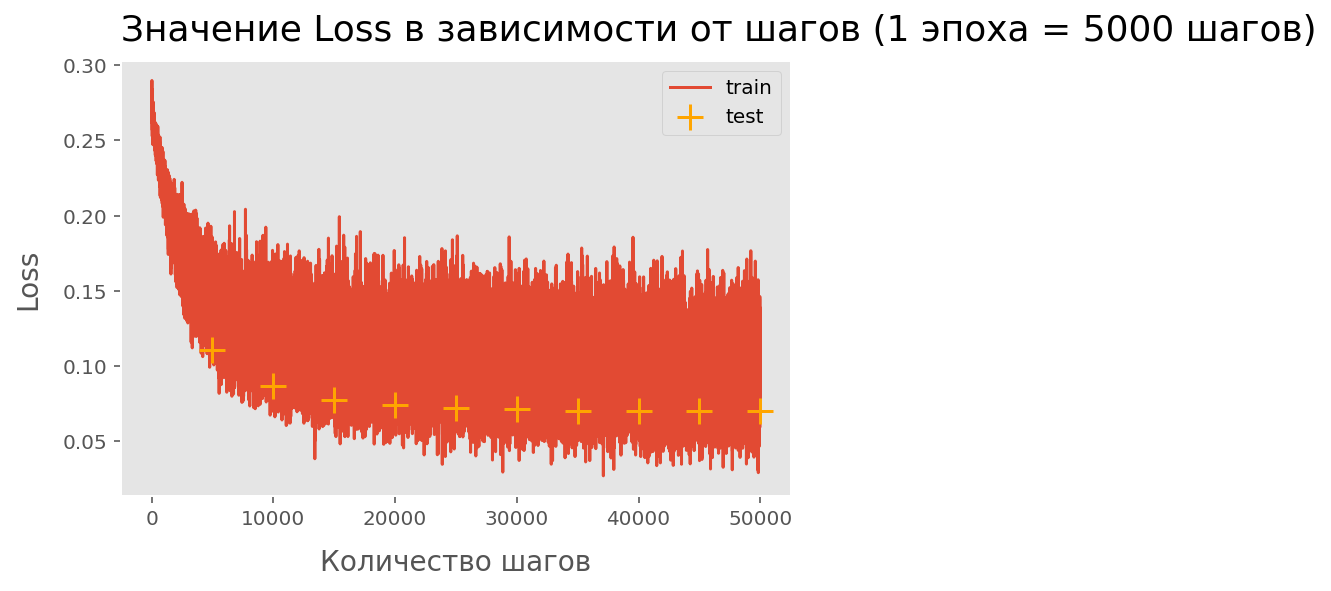

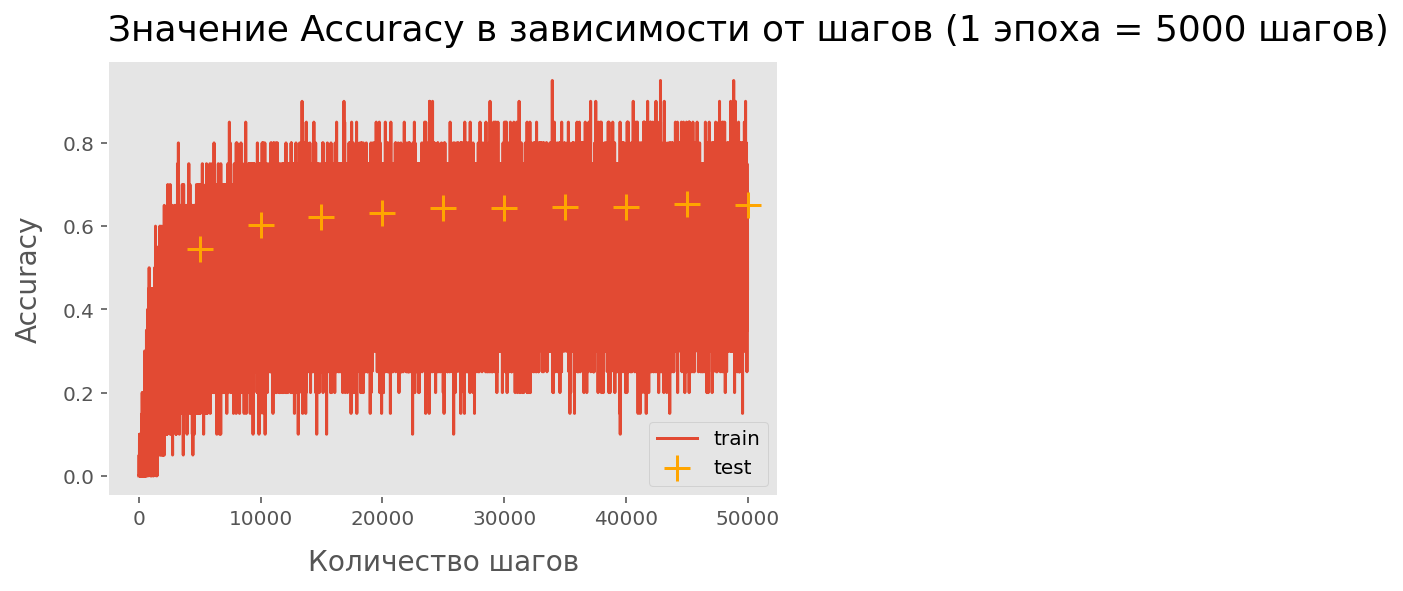

Test loss: 0.06975
Test accuracy: 64.99%


In [34]:
seed_everything(77)
train(model, train_dataloader, test_dataloader, criterion, optimizer, device, n_epochs, scheduler)

После всех экспериментов которые вы проделали, выберите лучшую из своих моделей, запустите функцию evaluate. Эта функция должна брать на вход модель и даталоадер с валидационными данными и возвращать accuracy, посчитанную на этом датасете.

In [35]:
test_loss, _, predicted_labels, true_labels = predict(model, test_dataloader, criterion, device)
assert len(predicted_labels) == len(test_dataloader)
# Расстягиваем лист листов в вектор
predicted_labels = torch.hstack(predicted_labels).to("cpu")
true_labels = torch.hstack(true_labels).to("cpu")
accuracy = accuracy_score(predicted_labels, true_labels)
print("Оценка за это задание составит {} баллов".format(min(5, 5*accuracy / 0.44)))

Loss: 0.05889, Accuracy: 75.0%: 100%|██████████| 500/500 [01:40<00:00,  4.97it/s]
Оценка за это задание составит 5 баллов


Также мы сделали и бонусное задание :)

In [36]:
accuracy

0.6499

__Ваш отчёт о проделанных экспериментах__: 

Перед обучением аугментировал обучающую выборку, чтобы нейросеть адаптировалась к поворотам картинки и прочему. В качестве нейросети взял ResNet, исходя из логики, что, если она обучалась на 1000 классах, значит уже знает множество паттернов и имеет большое количество хороших признаков, которые могут подойти к нашим 200 классам. ResNet с 152 слоями имеет 11,3 миллиарда параметров, но нам всего лишь надо было переобучить последний слой архитектуры — а именно полносвязный слой — так, что бы он выдавал 200 классов вместо 1000 классов. Оптимизировал с помощью Adam, так как он дает несмещенную оценку на квадрат градиента.


## Часть 2. Object detection.

В этом задании потребуется обучить детектор фруктов на изображении. Датасет можно скачать [отсюда](https://yadi.sk/d/UPwQB7OZrB48qQ).

Скачаем датасет также с Dropbox, а не Яндекса.

In [16]:
!wget https://www.dropbox.com/s/e120wzgzf34tfqx/archive.zip?dl=0 -O archive.zip
!unzip -q archive.zip

--2020-11-24 18:29:01--  https://www.dropbox.com/s/e120wzgzf34tfqx/archive.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.1, 2620:100:6016:1::a27d:101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/e120wzgzf34tfqx/archive.zip [following]
--2020-11-24 18:29:01--  https://www.dropbox.com/s/raw/e120wzgzf34tfqx/archive.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uce21294ef5354d5139b64be5e6a.dl.dropboxusercontent.com/cd/0/inline/BD2GQ0zTPAA2qxpFKhEShoc7G-y7S1wYzhVbLuoAAJIq1bzgYaQHBXA5FN8i0oWipIsw4w7-Eo9AqlM3oyzLRy3hFAA4J4iO6L9YbPjPe7cm5BT5s8zd5DAQg3uMJX4-Y1Y/file# [following]
--2020-11-24 18:29:01--  https://uce21294ef5354d5139b64be5e6a.dl.dropboxusercontent.com/cd/0/inline/BD2GQ0zTPAA2qxpFKhEShoc7G-y7S1wYzhVbLuoAAJIq1bzgYaQHBXA5FN8i0oWipIsw4w7-Eo9AqlM3oyzLRy3hFAA4J4iO6L9YbPjPe7cm5BT5

In [17]:
!ls

archive.zip  sample_data  test_zip  train_zip


In [18]:
# we will need this library to process the labeling
! pip install xmltodict

Обновляю библиотеку по аугментации.

In [19]:
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir

  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-5ha3lxd2
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-5ha3lxd2
  Created wheel for albumentations: filename=albumentations-0.5.1-cp36-none-any.whl size=72066 sha256=388e134f07aa82016a54da8b3ec4e3396457132b4b5144f523b9f4f2d96b64e4
  Stored in directory: /tmp/pip-ephem-wheel-cache-k74havpq/wheels/45/8b/e4/2837bbcf517d00732b8e394f8646f22b8723ac00993230188b
Successfully built albumentations
  Found existing installation: albumentations 0.5.1
    Uninstalling albumentations-0.5.1:
      Successfully uninstalled albumentations-0.5.1


Датасет мы за вас написали.

In [20]:
import pandas as pd
import xmltodict
import json
import glob
import albumentations as A
import cv2
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import auc


class2tag = {"apple": 1, "orange": 2, "banana": 3}


class FruitDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.images = []
        self.annotations = []
        self.transform = transform
        for annotation in glob.glob(data_dir + "/*xml"):
            image_fname = os.path.splitext(annotation)[0] + ".jpg"
            self.images.append(cv2.cvtColor(cv2.imread(image_fname), cv2.COLOR_BGR2RGB))
            with open(annotation) as f:
                annotation_dict = xmltodict.parse(f.read())
            bboxes = []
            labels = []
            objects = annotation_dict["annotation"]["object"]
            if not isinstance(objects, list):
                objects = [objects]
            for obj in objects:
                bndbox = obj["bndbox"]
                bbox = [bndbox["xmin"], bndbox["ymin"], bndbox["xmax"], bndbox["ymax"]]
                bbox = list(map(int, bbox))
                bboxes.append(torch.tensor(bbox))
                labels.append(class2tag[obj["name"]])
            self.annotations.append(
                {"boxes": torch.stack(bboxes).float(), "labels": torch.tensor(labels)}
            )

    def __getitem__(self, i):
        if self.transform:
            res = self.transform(
                image=self.images[i],
                bboxes=self.annotations[i]["boxes"],
                labels=self.annotations[i]["labels"],
            )
            return res["image"], {
                "boxes": torch.tensor(res["bboxes"]),
                "labels": torch.tensor(res["labels"]),
            }
        else:
            return self.images[i], self.annotations[i]

    def __len__(self):
        return len(self.images)

Выпишем кое-какую техническую работу, которая уже была на семинаре.

In [21]:
def intersection_over_union(dt_bbox, gt_bbox):
    """
    Intersection over Union between two bboxes
    :param dt_bbox: list or numpy array of size (4,) [x0, y0, x1, y1]
    :param gt_bbox: list or numpy array of size (4,) [x0, y0, x1, y1]
    :return : intersection over union
    """

    inter_x_0 = max(dt_bbox[0], gt_bbox[0])
    inter_x_1 = min(dt_bbox[2], gt_bbox[2])
    inter_y_0 = max(dt_bbox[1], gt_bbox[1])
    inter_y_1 = min(dt_bbox[3], gt_bbox[3])

    intersection = max(inter_x_1 - inter_x_0, 0) * max(inter_y_1 - inter_y_0, 0)

    space_dt = (dt_bbox[2] - dt_bbox[0]) * (dt_bbox[3] - dt_bbox[1])
    space_gt = (gt_bbox[2] - gt_bbox[0]) * (gt_bbox[3] - gt_bbox[1])
    union = space_dt + space_gt - intersection

    return intersection / union

In [22]:
def evaluate_sample(target_pred, target_true, iou_threshold=0.5):
    # правильные прямоугольники
    gt_bboxes = target_true['boxes'].numpy()
    gt_labels = target_true['labels'].numpy()

    # предсказания модели
    dt_bboxes = target_pred['boxes'].numpy()
    dt_labels = target_pred['labels'].numpy()
    dt_scores = target_pred['scores'].numpy()

    results = []
    # для каждого прямоугольника из предсказания находим максимально близкий прямоугольник среди ответов
    for detection_id in range(len(dt_labels)):
        dt_bbox = dt_bboxes[detection_id, :]
        dt_label = dt_labels[detection_id]
        dt_score = dt_scores[detection_id]

        detection_result_dict = {'score': dt_score}

        max_IoU = 0
        max_gt_id = -1
        for gt_id in range(len(gt_labels)):
            gt_bbox = gt_bboxes[gt_id, :]
            gt_label = gt_labels[gt_id]

            if gt_label != dt_label:
                continue

            if intersection_over_union(dt_bbox, gt_bbox) > max_IoU:
                max_IoU = intersection_over_union(dt_bbox, gt_bbox)
                max_gt_id = gt_id

        
        if max_gt_id >= 0 and max_IoU >= iou_threshold:
            # для прямоугольника detection_id нашли правильный ответ, который имеет IoU больше 0.5 
            detection_result_dict['TP'] = 1
            # удаляем эти прямоугольники из данных, чтобы больше не матчить с ними
            gt_labels = np.delete(gt_labels, max_gt_id, axis=0)
            gt_bboxes = np.delete(gt_bboxes, max_gt_id, axis=0)

        else:
            detection_result_dict['TP'] = 0

        results.append(detection_result_dict)

    # возвращаем результат, для кажого прямоугольника говорим, смогли ли сматчить его с чем то из ответов
    return results

In [23]:
def evaluate(model, test_loader, device):
    results = []
    model.eval()
    nbr_boxes = 0
    with torch.no_grad():
        for batch, (images, targets_true) in enumerate(test_loader):
            images = list(image.to(device).float() for image in images)
            targets_pred = model(images)

            targets_true = [{k: v.cpu().float() for k, v in t.items()} for t in targets_true]
            targets_pred = [{k: v.cpu().float() for k, v in t.items()} for t in targets_pred]

            for i in range(len(targets_true)):
                target_true = targets_true[i]
                target_pred = targets_pred[i]
                nbr_boxes += target_true['labels'].shape[0]

                # матчим ответы с правильными боксами
                results.extend(evaluate_sample(target_pred, target_true))

    results = sorted(results, key=lambda k: k['score'], reverse=True)

    # считаем точность и полноту, чтобы потом посчитать mAP как auc
    acc_TP = np.zeros(len(results))
    acc_FP = np.zeros(len(results))
    recall = np.zeros(len(results))
    precision = np.zeros(len(results))

    if results[0]['TP'] == 1:
        acc_TP[0] = 1
    else:
        acc_FP[0] = 1

    for i in range(1, len(results)):
        acc_TP[i] = results[i]['TP'] + acc_TP[i - 1]
        acc_FP[i] = (1 - results[i]['TP']) + acc_FP[i - 1]

        precision[i] = acc_TP[i] / (acc_TP[i] + acc_FP[i])
        recall[i] = acc_TP[i] / nbr_boxes

    return auc(recall, precision)

__Задание__. Обучите модель для object detection на __обучающем__ датасете и добейтесь PR-AUC не менее __0.91__ на  __тестовом__.

 - Создайте модель и оптимайзер
 - Напишите функцию обучения модели
 - Используйте аугментации
 
Использовать аугментации для обучения __обязательно__. Они дадут 1 балл из 5. Пользуйтесь модулем torchvision.transforms или библиотекой albumentations (о которой говорилось ранее). Последняя библиотека особенно удобна, поскольку умеет сама вычислять новые координаты bounding box'ов после трансформаций картинки. Советуем обратить внимание на следующий [гайд](https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/). Обратите внимание, что код, написанный в датасете выше, верен только если вы используете albumentations. Если вы выбрали путь torchvision.transforms, вам потребуется метод `__getitem__` изменить (что-то типа `return self.transform(self.images[i])`; однако в таком случае вычислять новые координаты bounding box'ов после трансформаций вам придётся вручную.

Оставшиеся 4 балла вычисляются по простой формуле: __min(4, 4 * Ваш auc / 0.91)__.

In [24]:
from albumentations.pytorch.transforms import ToTensor

# Применяем аугментации для картинок в обучающей выборке
train_transform = A.Compose([A.Rotate(p=0.5),
                             A.VerticalFlip(p=0.5),
                             A.HorizontalFlip(p=0.5), 
                             A.RandomBrightnessContrast(p=0.2),
                             ToTensor()], 
                             bbox_params=A.BboxParams(format='pascal_voc',
                                                      label_fields=['labels']))

test_transform = A.Compose([ToTensor()])

train_dataset = FruitDataset("./train_zip/train", transform=train_transform)
test_dataset = FruitDataset("./test_zip/test", transform=test_transform)

Посмотрим на картинки.

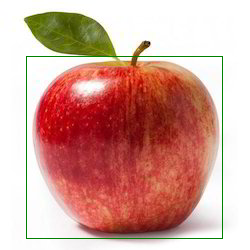

In [26]:
image, targets_true = train_dataset[-5]
image = transforms.ToPILImage()(image)
draw = ImageDraw.Draw(image)
for box in targets_true['boxes']:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline='green')

image

Определим `collate_fn` — функцию, принимающуюся к каждому элементу датасета, с помощью которой формируется по заданным условиям батч. Например, у нас батч 
формируется следующим образом: $((image_1, ..., image_m), (target_1, ..., target_m))$, где $m$ — число элементов в батче.

In [27]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [28]:
seed_everything(77)
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=4, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=2, num_workers=4, collate_fn=collate_fn)

Определим функции для обучения нейросети.

In [29]:
def train_one_epoch(model, train_dataloader, optimizer, device):
    model.train()

    loss_acum = 0
    steps = len(train_dataloader)

    for images, targets_true in train_dataloader:
        images = [image.to(device).float() for image in images]
        targets_true = [{k: v.to(device) for k, v in t.items()} for t in targets_true]

        loss_dict = model(images, targets_true)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
            
        loss_acum += float(losses.cpu().detach().numpy())

    return loss_acum/steps

def train(model, train_dataloader, test_dataloader, optimizer, device, n_epochs=10):
    for epoch in range(n_epochs):
        print(f"Epoch: {epoch}")
        loss = train_one_epoch(model, train_dataloader, optimizer, device)
        print(f"Loss is {loss:.3}, ")
        lr_scheduler.step()
        auc = evaluate(model, test_dataloader, device)
        print(f"Test AUC is {auc:.3}\n")

Снова воспользуемя Transfer Learning: возьмем Faster R-CNN.

In [30]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import fasterrcnn_resnet50_fpn

model = fasterrcnn_resnet50_fpn(pretrained=True)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


Заменим последний слой на наш и обучим его.

In [31]:
# У нас по факту 4 класса: фрукты и фон
model.roi_heads.box_predictor = FastRCNNPredictor(1024, 4)
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample)

In [34]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

seed_everything(77)
train(model, train_dataloader, test_dataloader, optimizer, device, n_epochs=7)

Epoch: 0
Loss is 0.203, 
Test AUC is 0.831

Epoch: 1
Loss is 0.199, 
Test AUC is 0.888

Epoch: 2
Loss is 0.189, 
Test AUC is 0.868

Epoch: 3
Loss is 0.197, 
Test AUC is 0.913

Epoch: 4
Loss is 0.176, 
Test AUC is 0.918

Epoch: 5
Loss is 0.173, 
Test AUC is 0.92

Epoch: 6
Loss is 0.172, 
Test AUC is 0.919



__Выведите итоговое качество модели__.

In [35]:
auc = evaluate(model, test_dataloader, device=device)
print("Оценка за это задание составит {} баллов".format(min(4, 4 * auc / 0.91)))

Оценка за это задание составит 4 баллов


Нарисуйте предсказанные bounding box'ы для любых двух картинок из __тестового__ датасета.

In [42]:
image, labels = test_dataset[-3]
pred = model(image.unsqueeze(0).to(device))[0]

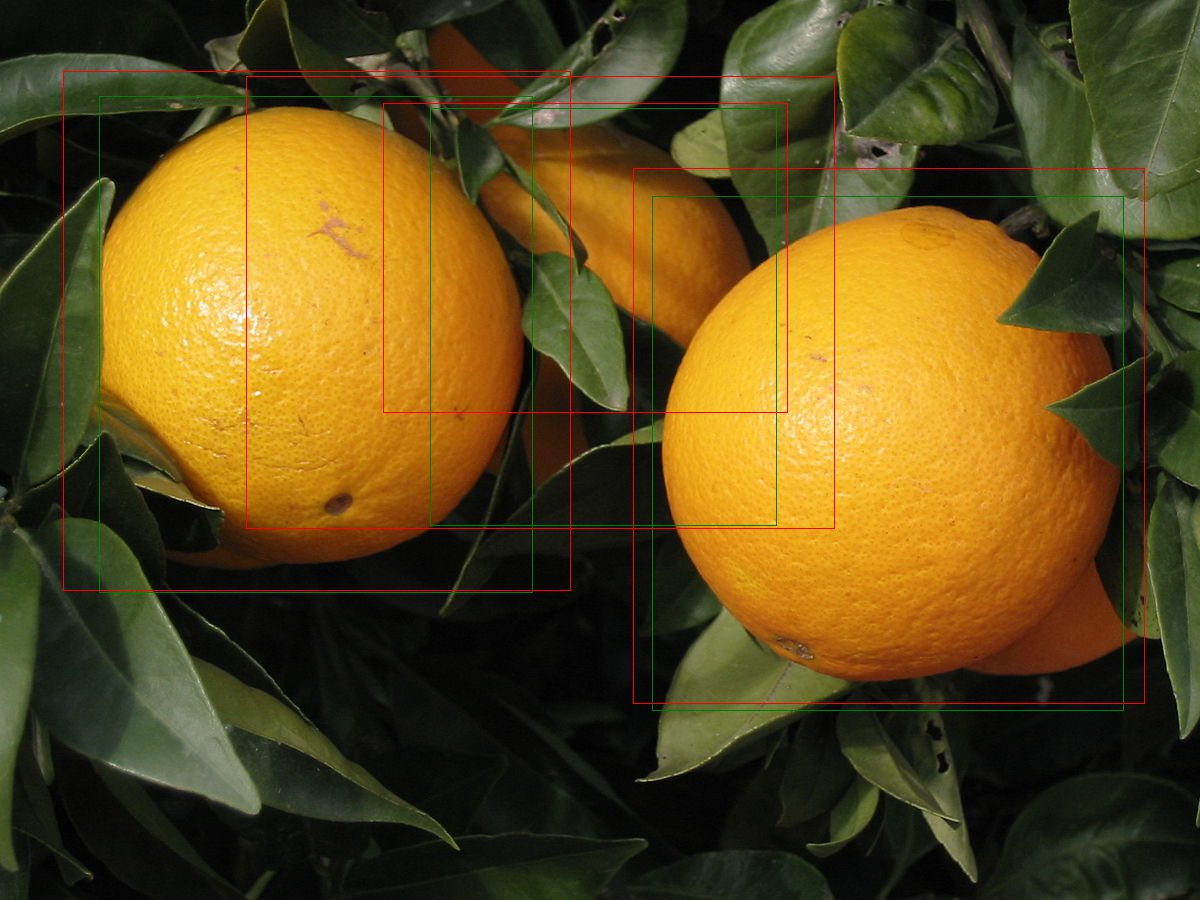

In [43]:
image = transforms.ToPILImage()(image)
draw = ImageDraw.Draw(image)
for box in labels['boxes']:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline='green')
    
for box in pred['boxes']:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline='red')
image

## Бонус (10 баллов).

__Задание__. В части с классификацией добейтесь accuracy не менее 0.52. Напишите отчёт о проделанных экспериментах. // (Можно резолюшен картинки увеличить, мб это будет полезно)

__Критерии оценки__. Оценка за бонусную часть равна 10, если вы преодолели качество 0.52 и 0 в противном случае.

__Иных оценок кроме 0 и 10 не предусмотрено__.

Уже сделал.

## Бонус (0 баллов).

__Задание 1__. Скиньте ниже смешную картинку, желательно про машинное обучение. На картинке не должно быть никаких упоминаний лектора, семинаристов и ассистентов этого курса.

Лучший мем лежит в первом датасете:

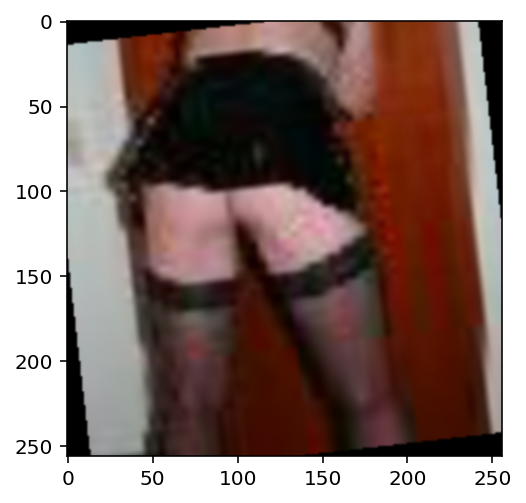

In [ ]:
image, label = train_dataset.__getitem__(58*500 + 64) 
plt.imshow(transforms.ToPILImage()(image), interpolation="bicubic");

__Задание 2__. Расскажите, как вам задание? Что понравилось, что не понравилось, что можно улучшить? Мы примем во внимание любой фидбек.

1) Касательно этой домашки: хотелось бы посложнее, первая зашла больше. Правда, там дедлайн не очень удобный был: прямо перед экзаменом по макроэкономике.

2) Касательно лекций и материала: хотелось бы больше математики и формальностей.